# Desenho e Análise de Algoritmos (DAA)
## Minitrabalho – "Seam Carving" - Grupo 50
### Trabalho realizado por: Pedro Vaz, nº111322 | Rodrigo Diogo, nº111516

### **1) Classes auxiliares para construção de estruturas de grafo (Vertex, Edge, Graph e DiGraph):**

In [1]:
# Class Vertice
class Vertex:
    ''' Estrutura de Vértice para um grafo: encapsula um elemento (vertex_id) 
        que é o identificador deste nó.
        
        O elemento (vertex_id) deve ser hashable:  
        - Um objeto hashable é aquele que pode ser utilizado como uma chave num dicionário Python.
        - Isto inclui strings, números, tuplas, etc.
    '''
    
    def __init__(self, vertex_id):
        '''O vértice será inserido no Grafo usando o método insert_vertex(x) que cria um Vertex'''
        self._vertex_id = vertex_id   # Id do vértice (elemento a inserir no grafo)
        
    def __hash__(self):
        '''O valor do elemento é usado como hash para o vértice (o elemento deve ser hashable)'''
        return hash(self._vertex_id)  # devolve o hash do elemento

    def __str__(self):
        '''Devolve a representação do objeto vértice em string.'''
        return'v{0}'.format(self._vertex_id)

    def __eq__(self, vertex):
        return self._vertex_id == vertex._vertex_id # Deve-se garantir que: se hash(vertex)==hash(self), entao vertex==self

    def __lt__(self, vertex):
        return self._vertex_id < vertex._vertex_id
    
    def __le__(self, vertex):
        return self._vertex_id <= vertex._vertex_id
    
    def __gt__(self, vertex):
        return self._vertex_id > vertex._vertex_id
    
    def __ge__(self, vertex):
        return self._vertex_id >= vertex._vertex_id
    
    def vertex_id(self):
        ''' Devolve o elemento guardado neste vértice.'''
        return self._vertex_id

In [2]:
# Class Edge
class Edge:
    ''' Estrutura de Aresta para um Grafo: (origem, destino) e peso '''

    def __init__(self, vertex_1, vertex_2, weight):
        self._vertex_1 = vertex_1
        self._vertex_2 = vertex_2
        self._weight = weight

    def __hash__(self):
        # Função que mapeia a aresta a uma posição no dicionário (hash map)
        return hash( (self._vertex_1, self._vertex_2) )

    def __str__(self):
        ''' Devolve a representação do objeto aresta em string: (origem, destino)w=peso '''
        return'e({0},{1})w={2}'.format(self._vertex_1, self._vertex_2, self._weight)

    def __eq__(self, other):
        # define igualdade de duas arestas (deve ser consistente com a função hash)
        return self._vertex_1 == other._vertex_1 and self._vertex_2 == other._vertex_2

    def endpoints(self):
        ''' Devolve a tupla (vertex_1, vertex_2) os vértices adjacentes vertex_1 e vertex_2.'''
        return (self._vertex_1, self._vertex_2)

    def cost(self):
        ''' Devolve o peso associado a este arco.'''
        return self._weight
    
    def opposite(self, vertex):
        ''' Indica o vértice oposto ao vertex nesta aresta 
            (apenas se vertex fizer parte da aresta).'''
        if vertex == self._vertex_1:
            return self._vertex_2
        elif vertex == self._vertex_2:
            return self._vertex_1
        else:
            return None

In [3]:
class Graph:
    '''
    Representação de um grafo usando dicionários encadeados (nested dictionaries).
    
    Atributos:
    ----------
    adjancencies: Dicionário externo que associa um vértice (Vertex) a um  
                  mapa de adjacências (dicionario interno)
                  Em vez de utilizar uma estrutura com um array (como nos slides),
                  utiliza uma estrutura do tipo "dicionário de dicionários":
                  < vertex , < neighbor_vertex , edge > >
                  
    vertices: Dicionário auxiliar que associa o id dos vértices do grafo
              a um objeto Vertex (tabela de símbolos):
              < vertex_id , vertex >
              
    n: Número de vértices no Grafo
    m: Número de arestas no Grafo
    
    ----------
'''
    def __init__(self):
        '''Construtor: Cria um grafo vazio (dicionário de _adjancencies).'''
        self._adjancencies = {}  # dicionário que associa o par chave-valor: <Vertex v, Mapa de adjacências de v> 
        self._vertices = {}      # dicionário que associa o par: <id do vértice, objeto Vertex correspondente> 
        self._n = 0              # número de vértices do grafo
        self._m = 0              # número de arestas do grafo
        
    def __str__(self):
        '''Devolve a representação do grafo em string (toString)'''
        if self._n == 0:
            ret = "DAA-Graph: <empty>\n"
        else:
            ret = "DAA-Graph:\n"
            for vertex in self._adjancencies.keys():
                #ret += "vertex-"
                ret += str(vertex) + ": "
                for edge in self.incident_edges(vertex.vertex_id()):
                    ret += str(edge) + "; "
                ret += "\n"
        return ret
    
    def is_directed(self):
        '''A classe Graph representa um grafo não orientado.'''
        return False
    
    def order(self):
        '''Ordem de um grafo: a quantidade de vértices no Grafo.'''
        return self._n
    
    def size(self):
        '''Dimensão de um grafo: a quantidade total de arestas do Grafo.'''
        return self._m 
    
    def has_vertex(self, vertex_id):
        '''Verifica se o vértice de id vertex_id está no grafo.'''
        return vertex_id in self._vertices
    
    def has_edge(self, u_id, v_id):
        '''Verifica se a aresta (u_id, v_id) existe no grafo.'''
        if not self.has_vertex(u_id) or not self.has_vertex(v_id):
            return False
        else:
            vertex_u = self._vertices[u_id]
            vertex_v = self._vertices[v_id]
            return vertex_v in self._adjancencies[vertex_u]
        
    def insert_vertex(self, vertex_id):
        '''Insere um novo vértice com o id vertex_id.'''
        if not self.has_vertex(vertex_id):
            vertex = Vertex(vertex_id)          # instancia um objeto do tipo Vertex
            self._vertices[vertex_id] = vertex  # insere o novo vértice no dicionário de vertices
            self._adjancencies[vertex] = {}     # inicializa o mapa de adjacências deste vértice a vazio
            self._n +=1                         # mais um vértice no grafo

    def insert_edge(self, u_id, v_id, weight=0):
        ''' Cria e insere uma nova aresta entre u_id e v_id com peso weight.
            Se a aresta já existe no grafo, atualiza-se o seu peso.
            Também insere os vértices u_id e v_id, caso não existam.'''
        if not self.has_vertex(u_id):
            self.insert_vertex(u_id) # insere novo vertex e atualiza n
        if not self.has_vertex(v_id):
            self.insert_vertex(v_id) # insere novo vertex e atualiza n      
        if not self.has_edge(u_id, v_id):
            self._m +=1           # atualiza m apenas se a aresta ainda não existir no grafo
        else:
            print(f"Existing edge {u_id} and {v_id}. Will only update weight")
        vertex_u = self._vertices[u_id]  # acede ao objeto Vertex associado a u_id
        vertex_v = self._vertices[v_id]  # acede ao objeto Vertex associado a v_id
        e = Edge(vertex_u, vertex_v, weight)    
        self._adjancencies[vertex_u][vertex_v] = e  # coloca v nas adjacências de u
        self._adjancencies[vertex_v][vertex_u] = e  # e u nas adjacências de v (para facilitar a procura de todas as arestas incidentes num vértice)
    
    def degree(self, vertex_id):
        '''Quantidade de arestas incidentes no vértice v.
        '''
        return len(self._adjancencies[self._vertices[vertex_id]])
    
    def get_vertex(self, vertex_id):
        ''' Devolve o objeto Vertex associado ao elemento vertex_id no grafo
        '''
        return None if not self.has_vertex(vertex_id) else self._vertices[vertex_id] 
    
    def get_edge(self, u_id, v_id):
        ''' Devolve o objeto aresta (Edge) que liga u_id a v_id. 
            Devolve None se não forem adjacentes ou se (um d)os vértices não existirem.'''  
        if not self.has_edge(u_id, v_id):
            return None
        else:
            vertex_u = self._vertices[u_id]
            vertex_v = self._vertices[v_id]
            return self._adjancencies[vertex_u][vertex_v]
    
    def vertices(self):
        '''Devolve um iterável sobre todos os vértices do Grafo (tipo Vertex)'''
        return self._vertices.values()

    def edges(self):
        '''Devolve um iterável sobre todas as arestas do Grafo (sem arestas duplicadas).'''
        seen = {}      # evita a repetição de arestas no grafo não orientado
        for adj_map in self._adjancencies.values():
            for edge in adj_map.values():
                if edge not in seen:
                    yield edge
                seen[edge] = True

    def incident_edges(self, vertex_id):
        '''Devolve um iterável (gerador) com todas as arestas de um vértice com id vertex_id.'''
        vertex = self._vertices[vertex_id]
        for edge in self._adjancencies[vertex].values(): # para todas as arestas incidentes em v:
            yield edge

    def has_neighbors(self, vertex_id):
        '''Verifica se o vértice de id vertex_id tem vértices adjacentes (vizinhos).'''
        if not self.has_vertex(vertex_id):
            return False
        return self.degree(vertex_id) == 0
    
    def remove_vertex(self, vertex_id):
        '''Remove o vértice com id vertex_id. Se o vértice não existir, não faz nada.'''
        # Passo 1: remover todas as arestas do vértice dado
        # Passo 2: remover todas as arestas incidentes em vertex_id dos mapas de outros vertices
        # Passo 3: remover o vértice com id vertex_id do grafo
        # Passo 4: decrementa contador de vértices
        if self.has_vertex(vertex_id):
            lst_copied = list(self.incident_edges(vertex_id)) # copia para a lista para evitar erros de concorrência (remove enquanto itera na lista)
            for edge in lst_copied:
                x, y = edge.endpoints()
                self.remove_edge(x.vertex_id(),y.vertex_id())  # (Passos 1 e 2)
            del self._adjancencies[self._vertices[vertex_id]]  # (Passo 3 - remove do dicionário de adjacências)
            del self._vertices[vertex_id]                      # (Passo 3 - remove do dicionário de vértices)
            self._n -=1                                        # (Passo 4 - decrementa contador)
        
    def remove_edge(self, u_id, v_id):
        '''Remove a aresta entre u_id e v_id. Se a aresta não existir, não faz nada.'''
        if  self.has_edge(u_id, v_id):
            vertex_u = self._vertices[u_id]
            vertex_v = self._vertices[v_id]
            del self._adjancencies[vertex_u][vertex_v]
            if vertex_u != vertex_v:  # laços são removidos apenas uma vez
                del self._adjancencies[vertex_v][vertex_u]
            self._m -=1


In [4]:
#  ### Classe DiGrafo
class DiGraph(Graph):
    '''
    Representação de um digrafo usando dicionários encadeados (nested dictionaries).
    
    Atributos:
    ----------
    in_adjancencies: Dicionário dos arcos de entrada (mapa contém antecessores)
    
    ----------
    
    
    Atributos herdados da classe Graph :
    ----------
    adjancencies: Dicionário dos arcos de saída (mapa contém sucessores)
    vertices: Dicionário que associa o id dos nós do grafo a um objeto Vertex (tabela de símbolos).
    n: Número de nós no Grafo
    m: Número de arcos no Grafo
    ----------
   
   
    Métodos herdados da classe Graph (que não são sobrescritos nesta classe):
    ----------
    order(): Devolve o número de nós do grafo - Deve-se manter o atributo super()._n atualizado
    size(): Devolve o número de arestas do grafo - Deve-se manter o atributo super()._m atualizado
    has_vertex(v_id):  Verifica se o nó com id v_id está no grafo - Os dois mapas de adjacências devem conter o mesmo conjunto de nós
    has_edge(u_id, v_id): Verifica se existe o arco u_id -> v_id - O atributo super()._adjancencies contém todos os sucessores    
    get_edge(u_id, v_id): Devolve o arco u_id -> v_id, se existir.      
    degree(v_id): Devolve o mesmo que out_degree(v_id)
    has_neighbors(v_id): Verifica se o nó v_id tem nós adjacentes (sucessores)
    vertices(): Devolve um iterável com os vértices (tipo Vertex) contidos no grafo.
    incident_edges(v_id): Devolve o mesmo que successors(v_id)
    ----------
'''

    def __init__(self):
        '''Construtor: Cria um grafo vazio (dicionário de _adjancencies).'''
        super().__init__()
        self._in_adjancencies = {}     # dicionário com chave vértice e valor mapa de adjacências das arestas de entrada
                
    def is_directed(self):
        '''A classe DiGraph representa um grafo orientado.'''
        return True
    
    def __repr__(self):
        '''Devolve a representação completa do grafo em string (debug).'''
        if self._n == 0:
            ret = "DAA-DiGraph out-Representation: <empty>\n"
            ret += "DAA-DiGraph in-Representation: <empty>\n"
        else:
            ret = "DAA-DiGraph out-Representation:\n"
            for vertex in self._adjancencies.keys():
                ret += str(vertex)
                ret += " out-deg " + str(self.out_degree(vertex.vertex_id())) + ":\t"
                for edge in self.successors(vertex.vertex_id()):
                    ret += str(edge) + "; "
                ret += "\n"
            ret += "DAA-DiGraph in-Representation:\n"
            for vertex in self._in_adjancencies.keys():
                ret += str(vertex)
                ret += " in-deg " + str(self.in_degree(vertex.vertex_id())) + ":\t"
                for edge in self.predecessors(vertex.vertex_id()):
                    ret += str(edge) + "; "
                ret += "\n"
        return ret
    
    def __str__(self):
        '''Devolve a representação do grafo em string.'''
        if self._n == 0:
            ret = "DAA-DiGraph: <empty>\n"
        else:
            ret = "DAA-Graph:\n"
            for vertex in self._adjancencies.keys():
                #ret += "vertex-"
                ret += str(vertex) + ": "
                for edge in self.successors(vertex.vertex_id()):
                    ret += str(edge) + "; "
                ret += "\n"
        return ret
     
    def is_successor(self, u_id, v_id):
        """Verifica se o nó u é sucessor do vértice v no grafo."""
        return super().has_edge(v_id, u_id)
        
    def is_predecessor(self, u_id, v_id):
        """ Verifica se o vértice u é antecessor do vértice v no grafo.
            Corresponde ao método super().has_edge(u,v). """
        return super().has_edge(u_id, v_id)
        
    def insert_vertex(self, vertex_id):
        '''Insere um novo nó com id vertex_id.'''
        super().insert_vertex(vertex_id)   # inicializa o mapa dos arcos de saída (_adjancencies)
        vertex = self._vertices[vertex_id]
        self._in_adjancencies[vertex] = {}  # inicializa o mapa dos arcos de entrada (_in_adjancencies)
        
    def insert_edge(self, u_id, v_id, weight=0):
        ''' Cria e insere um novo arco entre u_id e v_id com peso weight.
            Se o arco já existe no grafo, atualiza-se o seu peso.
            Também insere os nós u_id e v_id, caso não existam.'''
        if not self.has_vertex(u_id):
            self.insert_vertex(u_id) # insere novo vertex e atualiza n
        if not self.has_vertex(v_id):
            self.insert_vertex(v_id) # insere novo vertex e atualiza n      
        if not self.has_edge(u_id, v_id):
            self._m +=1           # atualiza m apenas se a aresta ainda não existir no grafo
        else:
            print(f"Existing edge {u_id} and {v_id}. Will only update weight")
        vertex_u = self._vertices[u_id]
        vertex_v = self._vertices[v_id]
        e = Edge(vertex_u, vertex_v, weight)    
        self._adjancencies[vertex_u][vertex_v] = e  # coloca v nas adjacências de u
        self._in_adjancencies[vertex_v][vertex_u] = e  # e u nas adjacências de v (para facilitar a procura de todas as arestas incidentes num vértice)
        
    def out_degree(self, vertex_id):
        '''Quantidade de arcos que saem do nó v.
        '''
        return len(self._adjancencies[self._vertices[vertex_id]]) # Verifica o tamanho do mapa de saída de v
    
    def in_degree(self, vertex_id):
        '''Quantidade de arcos que entram no nó v.
        '''
        return len(self._in_adjancencies[self._vertices[vertex_id]]) # Verifica o tamanho do mapa de entrade de v

    def edges(self):
        '''Devolve um iterável sobre todos os arcos do Grafo.'''
        for adj_map in self._adjancencies.values():
            for edge in adj_map.values():
                yield edge
                
    def successors(self, vertex_id): # igual ao super().incident_edges(v)
        '''Devolve um iterável com todos os arcos que saem de v.'''
        return self.incident_edges(vertex_id)
        '''
        vertex = self._vertices[vertex_id]
        for edge in self._adjancencies[vertex].values(): # para todas os arcos que saem do vértice
            yield edge 
            '''
            
    def predecessors(self, vertex_id):
        '''Devolve um iterável com todos os arcos que entram em v.'''
        vertex = self._vertices[vertex_id]
        for edge in self._in_adjancencies[vertex].values(): # para todas os arcos que entram no vértice
            yield edge 
    
    def remove_edge(self, u_id, v_id):
        '''Remove o arco u_id -> v_id. Se o arco não existir, não faz nada.'''
        if  self.has_edge(u_id, v_id):
            vertex_u = self._vertices[u_id]
            vertex_v = self._vertices[v_id]
            del self._adjancencies[vertex_u][vertex_v]
            del self._in_adjancencies[vertex_v][vertex_u]
            self._m -=1
       
    def remove_vertex(self, vertex_id):
        '''Remove o nó com id vertex_id. Se o nó não existir, não faz nada.'''
        # Passo 1: remover todos os arcos que saem do vértice dado
        # Passo 2: remover todos os arcos que entram no vértice dado
        # Passo 3: remover o vértice do grafo
        if self.has_vertex(vertex_id):
            lst_out = list(self.successors(vertex_id)) # copia para a lista para evitar erros de concorrência
            for edge in lst_out:
                x, y = edge.endpoints()
                self.remove_edge(x.vertex_id(),y.vertex_id())       # (Passos 1)
            lst_in = list(self.predecessors(vertex_id)) # copia para a lista para evitar erros de concorrência
            for edge in lst_in:
                x, y = edge.endpoints()
                self.remove_edge(x.vertex_id(),y.vertex_id())       # (Passos 2)
            del self._adjancencies[self._vertices[vertex_id]]     # (Passo 3 - remove do dicionário de saídas)
            del self._in_adjancencies[self._vertices[vertex_id]]  # (Passo 3 - remove do dicionário de entradas)
            del self._vertices[vertex_id]                         # (Passo 3 - remove do dicionário de vértices)
            self._n -=1 


### **2) Representação dos dados**

**Com base no conjunto de operações que a sua aplicação deve suportar (apresentadas na Secção 3) e na sua
interpretação do problema, descreva o modelo de grafo que utilizou para conceptualizar a relação entre os
pixels com energia no problema proposto. Liste quais foram os critérios que levaram à sua decisão e as
possíveis vantagens e desvantagens da representação usada em relação ao espaço em memória e o tempo
na execução das operações.**

#### ***Resposta***

Grafo utilizado:
Para resolvermos este problema de Seam Carving utilizámos a contrução de um grafo dirigido e pesado. Os vértices do grafo representam os pixeis da imagem selecionada e as arestas ligam os pixeis adjacentes na vertical. As arestas têm direção e têm o peso que corresponde à energia associada ao pixel de destino.
O grafo inclui dois vértices especiais:
- source: vértice que se conecta a todos os pixeis da 1ª linha no topo da imagem;
- sink: vértice que recebe conexões de todos os pixeis da última linha da imagem;
- o caminho que é estabelecido entre estes 2 vértices representa o caminho de menor energia que será removido.

Representação computacional do grafo:
Estamos a utilizar uma estrutra baseada em mapa de adjacências, através da classe DiGraph fornecida pelos professores. Assim, os vértices armazenam as respetivas arestas de saída e os respetivos custos (energia).

Vantagens:
- A estrutura de mapa de adjacências é geralmente melhor e mais eficiente em tempo e espaço para grafos esparsos, como o nosso, onde cada nó está ligado no máximo a 3 nós vizinhos.
- Esta estrutura permite uma implementação simples deste algoritmo, que foi escolhido pelo nosso grupo para este problema já que se trata de uma solução clássica para o problema de caminho mínimo em grafos com pesos positivos.
- Reflete bem e de uma forma direta a relação entre os pixeis que são adjacentes verticalmente.
- Boa separação da lógica pixeis/energia da lógica grafo/caminho mínimo.

Desvantagens:
- Sobrecarrega mais a memória quando comparada com a programação dinâmica (mais detalhes em 3.3.4)
- Não aproveitamento do grafo anterior, que é reconstruído a cada chamada do find_vertical_steam().

Utilizámos ambas as classes Graph e DiGraph, mas não lhes aplicámos qualquer modificação.

### **3) API SeamCarving**

**A sua aplicação terá de suportar as operações listadas na API abaixo (ver tabela) que redimensiona a largura
de uma imagem.**  
**Implemente cada uma dessas operações como um método de instância da classe SeamCarving.**

![](API_SeamCarving.png)

In [5]:
# Class SeamCarving
import numpy as np
import heapq

class SeamCarving:
    def __init__(self, image):
        """Contrutor que recebe a imagem como um ndarray."""
        self.image = image.astype(np.uint8) # Garante que a imagen está no formato correto
        self.height, self.width, _ = image.shape
        self.energy = self._calculate_energy()

    def _calculate_energy(self):
        # Converte para float64 para evitar overflow nos cálculos de subtração
        img = self.image.astype(np.float64)

        # Inicialização da matriz de energia
        energy = np.zeros((self.height, self.width), dtype=np.float64)

        # Gradientes de cor em x e em y
        dx = np.zeros((self.height, self.width, 3))
        dy = np.zeros((self.height, self.width, 3))

        # Calcula as diferenças entre os pixeis vizinhos em x
        dx[1:-1, :, :] = img[2:, :, :] - img[:-2, :, :]

        # Calcula as diferenças entre os pixeis vizinhos em y
        dy[:, 1:-1, :] = img[:, 2:, :] - img[:, :-2, :]

        # Energia final da imagem
        grad_x2 = np.sum(dx ** 2, axis=2)
        grad_y2 = np.sum(dy ** 2, axis=2)
        energy = np.sqrt(grad_x2 + grad_y2)

        return energy

    def find_vertical_steam(self):
        height, width = self.energy.shape

        # Grafp dirigido
        g = DiGraph()

        # Cria vértices para todos os pixels
        for y in range(height):
            for x in range(width):
                g.insert_vertex((x, y))

        # Cria vértices especiais
        source = (-1, -1)
        sink = (-2, -2)
        g.insert_vertex(source)
        g.insert_vertex(sink)

        # Adiciona arestas do "source" para todos os pixels da primeira linha (linha 0)
        for x in range(width):
            g.insert_edge(source, (x, 0), self.energy[0][x])


        # Adiciona arestas entre os pixels de cada linha
        for y in range(height - 1):  # até penúltima linha
            for x in range(width):
                current = (x, y)
                for dx in [-1, 0, 1]:  # esquerda, centro, direita
                    nx = x + dx
                    ny = y + 1
                    if 0 <= nx < width:
                        weight = self.energy[ny][nx]
                        g.insert_edge(current, (nx, ny), weight)

        # Adiciona arestas da última linha para o "sink"
        for x in range(width):
            g.insert_edge((x, height - 1), sink, 0)
    
        # Dijkstra a partir de "source"
        dist = {v.vertex_id(): float('inf') for v in g.vertices()}
        prev = {v.vertex_id(): None for v in g.vertices()}
        dist[source] = 0
        heap = [(0, source)]
    
        while heap:
            current_dist, u_id = heapq.heappop(heap)
            if current_dist > dist[u_id]:
                continue
            for edge in g.incident_edges(u_id):
                v = edge.opposite(g.get_vertex(u_id)).vertex_id()
                weight = edge.cost()
                if dist[u_id] + weight < dist[v]:
                    dist[v] = dist[u_id] + weight
                    prev[v] = u_id
                    heapq.heappush(heap, (dist[v], v))
    
        # Reconstrói caminho do sink até source
        path = []
        v = sink
        while prev[v] != source:
            v = prev[v]
            path.append(v)
        path.reverse()
        return path

    
    def remove_vertical_steam(self, steam):
        new_image = np.zeros((self.height, self.width - 1, 3), dtype=np.uint8)

        for y in range(self.height):
            x_to_remove = steam[y][0]
            row = np.delete(self.image[y, :, :], x_to_remove, axis=0)
            new_image[y, :, :] = row  # Isso só funciona se row tiver shape (width-1, 3)
            
        # Atualiza a imagem e os atributos
        self.image = new_image
        self.height, self.width, _ = self.image.shape
        self.energy = self._calculate_energy()

    def picture(self):
        return self.image
    

#### **3.1) Estrutura de dados**  

**Descreva a estrutura de dados utilizada para implementar a sua API. Apresente uma estimativa do espaço de
memória total utilizado pela sua aplicação para armazenar os atributos da classe SeamCarving em função
das dimensões da imagem original, ou seja, largura (W) e altura (H) da imagem**  

#### ***Resposta***

A classe SeamCarving utiliza uma estrutura de dados simples, sendo os seus atributos:
- self.image: matriz tridimensional do tipo numpy.ndarray que tem dimensões (H, W, 3), em que H é a altura, W é a largura e 3 é as componententes RGB.
- self.height: inteiro que armazena o valor da altura.
- self.width: inteiro que armazena o valor da largura.
- slef.energy: matriz NumPy de dimensão (H, W) que armazena os valores de energia para cada pixel da imagem.

Estimativa do espaço de memória total utilizada para armazenar os atributos da classe SeamCarving:
- self.image: ocupa $H \times W \times 3 \text{ bytes}$ (cada uint8 ocupa 1 byte)
- self.energy: ocupa $H \times W \times 8 \text{ bytes}$ (cada float64 do NumPy ocupa 8 bytes)
- self.height: inteiro que ocupa tipicamente 28 bytes
- self.width: inteiro que ocupa tipicamente 28 bytes

Memória Total: $3HW\ \text{bytes} + 8HW\ \text{bytes} + 28\ \text{bytes} + 28\ \text{bytes} = 11HW + 56\ \text{bytes}$

Para a imagem test_small.png que tem H = 61, W = 120, temos como memória total utilizada o valor: $11 \times 61 \times 120 + 56 = 80576\ \text{bytes}$

No seguinte código, vamos calcular a estimativa do espaço real ocupado pela classe para a imagem test_small.png, que está de acordo com o valor teórico calculado acima:

In [6]:
import numpy as np
from PIL import Image
import sys

# Carrega a imagem de teste
image = np.array(Image.open("test_small.png").convert("RGB"))
sc = SeamCarving(image)

# Espaço de memória estimado
print("Imagem:", sc.image.nbytes, "bytes")
print("Energia:", sc.energy.nbytes, "bytes")
print("Altura:", sys.getsizeof(sc.height), "bytes") # tamanho do inteiro
print("Largura:", sys.getsizeof(sc.width), "bytes") # tamanho do inteiro

# Total
total = sc.image.nbytes + sc.energy.nbytes + sys.getsizeof(sc.height) + sys.getsizeof(sc.width)
print("Total aproximado:", total, "bytes")

Imagem: 21960 bytes
Energia: 58560 bytes
Altura: 28 bytes
Largura: 28 bytes
Total aproximado: 80576 bytes


#### **3.2) Calcular a energia da imagem**  

**3.2.1) Implemente e teste a função auxiliar _calculate_energy() que irá calcular a energia da imagem atual.**
**A função deve devolver o mapa da energia da imagem como um ndarray (numpy array).**

### ***Resposta***

A função _calculate_energy() foi implementada na classe SeamCarving, e abaixo podemos ver o teste que demonstra a sua funcionalidade:

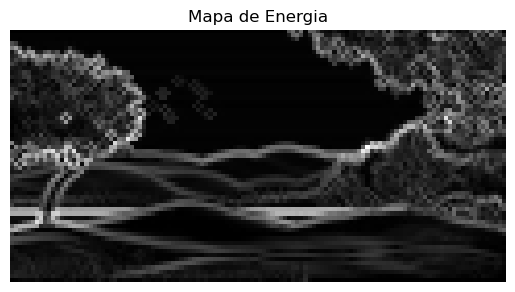

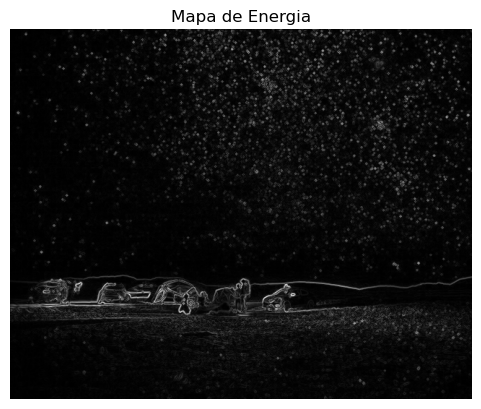

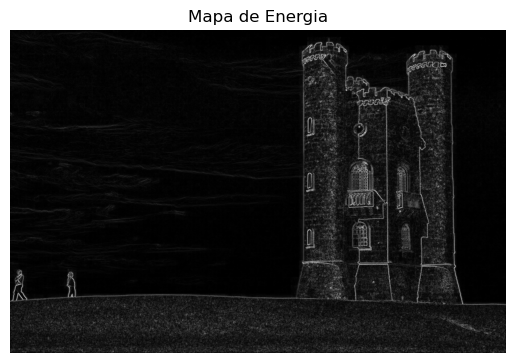

In [7]:
# Teste do mapa de enrgia calculado pela função _calculate_energy
import matplotlib.pyplot as plt
from PIL import Image

def testar_mapa_energia(caminho_imagem):
   
    img = np.array(Image.open(caminho_imagem).convert('RGB'))
    sc = SeamCarving(img)
    energia = sc.energy
    energia_norm = 255 * (energia - np.min(energia)) / (np.max(energia) - np.min(energia))
    energia_img = energia_norm.astype(np.uint8)

    # Mapa de energia
    plt.imshow(energia_img, cmap='gray')
    plt.title("Mapa de Energia")
    plt.axis('off')
    plt.show()

testar_mapa_energia("test_small.png")
testar_mapa_energia("img-brent-cox-unsplash.jpg")
testar_mapa_energia("img-broadway_tower.jpg")

**3.2.2) Apresente uma análise da complexidade desta função em relação ao tempo e ao espaço extra de memória utilizados (em função da dimensão da imagem).**  

#### ***Resposta***  

Consideramos que a imagem tem tamanho height * width = n, ou seja, n é o número de píxeis.

Complexidade temporal:
A função _calculate_energy(self) realiza operações vetorizadas que percorrem todos os pixeis da imagem e fazem cálculos simples:
- Conversão da imagem para o tipo float64: $O(n)$
- Criação de matrizes (energy, dx e dy): $O(n)$
- Cálculo dos gradientes dx e dy: $O(n)$
- Soma dos quadrados e a raiz quadrada: $O(n)$
Desta forma, temos que a complexidade temporal total é a soma das descritas anteriormente, ou seja, $O(n)$.

Complexidade espacial:
A função _calculate_energy(self) cria cópias auxiliares com o tamanho da imagem:
- A cópia da imagem em float64 (img), ocupa $3\ \text{bytes} \times 3\ \text{canais} \times n$
- Duas matrizes 3D com 3 canais (dx e dy): $2 \times 3 \times n$
- Três matrizes 2D do tipo float64 (grad_x2, grad_y2 e energy): $3 \times n$

Desta forma, temos que a complexidade espacial total é $9n + 6n + 3n = O(n)$.

#### **3.3) Encontrar a costura de menor energia (steam)**  

**3.3.1) Descreva os passos e as modificações realizadas no grafo e/ou no algoritmo para reduzir o problema do seam carving para o problema do caminho mais curto num grafo (shortest path). Indique qual algoritmo shortest path que escolheu implementar e o motivo da sua escolha.**  

#### ***Resposta***

Como referido anteriormente, em resposta à questão "2) Representação dos dados", utilizámos um grafo dirigido para resolver o problema do seam carving, sendo cada pixel da imagem um vértice desse grafo identificado pelas suas coordenadas (x, y). 

As arestas do grafo têm direção e apontam sempre para baixo já que a costura progirde verticalmente de cima para baixo. Assim, as arestas ligam cada pixel aos seus vizinho diretamente abaixo nas posições (x-1, y+1), (x, y+1) e (x+1,y+1). O custo, representado pelo peso de cada aresta, corresponde à energia do pixel de destino, o que quer dizer que é o custo de se mover para lá. 

Para facilitar, ainda criámos dois vértices especiais (source e sink) que definem o vértice de origem e o vértice de destino, ambos ligados a todos os pixeis da respetiva linha (primeira e última).

Para algoritmo de caminho mais curto escolhemos o algoritmo de Dijkstra, visto que é apropriado para o nosso problema com um grafo pesado cujos pesos (energi) são valores não negativos. Este algoritmo começa no vértice source e vai até o vértice sink, escolhendo sempre o vizinho de menor custo até lá chegar. Quando o caminho é por fim encontrado, estamos perante a costura vertical com energia mínima.

Como referido acima, escolhemos o Dijkstra já que é o ideal para garantir o caminho de menor custo em grafos dirigidos e pesados com pesos não negativos como o nosso. Para além disso, a estrutura do grafo é fixa e esparsa pois cada vértice tem no máximo 3 vizinhos. Por fim, a complexidade deste algoritmo com heap (fila de prioridade) é eficiente, como mostrado na resposta a 3.3.3).


**3.3.2) Implemente e teste o método find_vertical_steam()que deverá encontrar o caminho de menor energia**

#### ***Resposta***

O método finf_vertical_steam() foi implementado acima na classe SeamCarving. O teste que demonstra o funcionamento desta função está representado abaixo, onde o código devolve a lista de vértices do caminho vertical mais curto encontrado, representados pelas suas coordenadas:

In [8]:
# Caminho da imagem
caminho = r"img-broadway_tower.jpg"

# Abrir e converter para array numpy
imagem = Image.open(caminho).convert("RGB")
imagem_np = np.array(imagem)

# Incicializar a classe SeamCarving com a imagem
sc = SeamCarving(imagem_np)

# Encontrar o caminho que tem menor energia
vertical_seam = sc.find_vertical_steam()

# Mostrar o caminho
print("O caminho vertical encontrado foi:")
print(vertical_seam)

O caminho vertical encontrado foi:
[(937, 0), (937, 1), (937, 2), (938, 3), (937, 4), (936, 5), (937, 6), (937, 7), (937, 8), (936, 9), (937, 10), (938, 11), (939, 12), (940, 13), (941, 14), (942, 15), (941, 16), (940, 17), (939, 18), (939, 19), (939, 20), (938, 21), (938, 22), (939, 23), (938, 24), (937, 25), (936, 26), (935, 27), (934, 28), (933, 29), (932, 30), (931, 31), (931, 32), (931, 33), (932, 34), (931, 35), (931, 36), (932, 37), (931, 38), (931, 39), (930, 40), (929, 41), (930, 42), (931, 43), (932, 44), (933, 45), (934, 46), (935, 47), (936, 48), (937, 49), (937, 50), (937, 51), (936, 52), (935, 53), (936, 54), (936, 55), (935, 56), (934, 57), (934, 58), (935, 59), (934, 60), (933, 61), (933, 62), (932, 63), (933, 64), (932, 65), (931, 66), (931, 67), (931, 68), (931, 69), (931, 70), (931, 71), (932, 72), (933, 73), (933, 74), (933, 75), (933, 76), (933, 77), (932, 78), (933, 79), (933, 80), (932, 81), (932, 82), (933, 83), (932, 84), (931, 85), (931, 86), (931, 87), (932, 

**3.3.3) Apresente uma análise completa da complexidade do seu algoritmo em função da dimensão da imagem, e compare-a com a complexidade de outras versões do algoritmo shortest path.**  

#### ***Resposta***

Considerando que a imagem tem dimensões height (H) * width (W) e considerando os vértices source e sink, o número de vértices é $V = H \times W + 2$.

Cada pixel, exceto os da última linha, liga-se a até 3 pixeis da linha abaixo. A primeira linha tem W arestas e o mesmo acontece para a última linha que também tem W arestas. Assim, o número máximo de arestas é $E = 3 \times (H - 1) \times W + 2 \times W$. Logo, estamos perante uma complexidade de $O(H \times W) = O(HW)$.

Visto que estamos a utilizar o Dijkstra com uma fila de prioridade (heap) para encontrarmos o caminho de menor energia e, sabendo que a sua complexidade é $O(E\log(V))$, podemos concluir que a complexidade final do nosso algoritmo é $O(HW \log(HW))$.

Outros algoritmos clássicos para shortest path em grafos incluem:
- Bellman-Ford: Este algoritmo seria tolerante a grafos com pesos negativos, o que não seria relevante para este problema. Tem complexidade $O(V \cdot E)$, o que neste caso significaria $O(V \cdot E) = O(HW \cdot HW) = O(H^2 W^2)$, ou seja, é muito menos eficiente que o algoritmo que utilizámos.
- Dijkstra sem heap: Tem complexidade $O(V^2)$ no pior caso, o que neste caso significa $O((HW)^2) = O(H^2W^2)$. Assim, também é muito menos eficiente que o Dijkstra com heap.
- A* (A-Star): Por fim, este algoritmo é uma versão heurística do Dijkstra, sendo eficiente quando há uma boa estimativa do custo que falta para a solucionar o problema. Como no nosso problema, o caminho mais curto pode terminar em qualquer pixel da última linha, a heurística não é uma vantagem.



**3.3.4) Analise e compare a complexidade do seu algoritmo baseado em grafos com uma solução que utiliza
a estratégia de programação dinâmica. Na sua pesquisa bibliográfica e análise, deve usar fontes credíveis, tais
como, artigos científicos, manuais técnicos ou recursos webgráficos devidamente acreditados.**  

#### ***Resposta***

A estratégia de programação dinâmica é abordagem mais clássica e eficiente para encontrar a costura vertical de menor energia no problema de Seam Carving.

Primeiro constrói-se uma matriz dp[y][x] onde cada posição armazena a energia mínima para chegar ao pixel (x, y) a partir do topo. Desta maneira, a recorrência é: dp[y][x] = energy[y][x] + min(dp[y-1][x-1], dp[y-1][x], dp[y-1][x+1]). Depois, percorre-se o último nível da matriz de forma a encontrar o valor mínimo e reconstrói-se o caminho de forma eficiente.

Utilizando esta estratégia, a complexidade, tanto no tempo quanto no espaço é de $O(HW)$. Assim, quando comparado à metodologia de grafos que implementámos neste minitrabalho, que tem complexidade $O(HW \log(HW))$, a programação dinâmica é mais eficiente. Para além disso, a programação dinâmica é de mais fácil implementação, o que a tornaria a melhor escolha para este trabalho.

Fontes:
- Aijaz, O., Ali, S. M., & Uyghur, Y. (2024). Analysis of Different Algorithmic Design Techniques for Seam Carving [Preprint]. arXiv. https://doi.org/10.48550/arXiv.2410.21207
- Avidan, S., & Shamir, A. (2007). Seam carving for content-aware image resizing. Mitsubishi Electric Research Laboratories (MERL). Retrieved from https://perso.crans.org/frenoy/matlab2012/seamcarving.pdf
- Wedler, W. (2007). Project 2: Image Resizing by Seam Carving. Carnegie Mellon University. Retrieved from https://www.cs.cmu.edu/afs/andrew/scs/cs/15-463/f07/proj2/www/wwedler/

#### **3.4) Remover uma costura (steam) da imagem**

**3.4.1) Implemente e teste o método remove_vertical_steam(steam) que recebe uma coleção com a sequência de pixels da costura, steam, e remove-os da imagem atual.**

#### ***Resposta***

A função remove_vertical_steam(steam) foi implementada acima na classe SeamCarving, já uma função que cria uma imagem simples e testa este método pode ser vista na célula abaixo:

Imagem original: (5, 5, 3)
Imagem após remover a costura: (5, 4, 3)


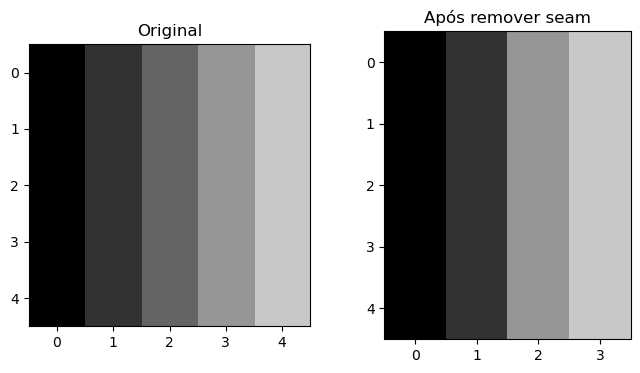

In [9]:
def test_remove_vertical_steam():
    # Imagem de teste simples: 5x5 com cores distintas por coluna
    test_image = np.zeros((5, 5, 3), dtype=np.uint8)
    for x in range(5):
        test_image[:, x] = x * 50 # Cada coluna terá uma cor distinta (0, 50, 100, 150, 200)

    sc = SeamCarving(test_image)

    # Costura artificial para teste: remove a coluna 2 em cada linha
    # Formato: [(x, y), ...] para cada y
    seam = [(2, y) for y in range(5)]

    print("Imagem original:", sc.image.shape)

    # Remover costura
    sc.remove_vertical_steam(seam)

    print("Imagem após remover a costura:", sc.image.shape)
    # Mostrar a imagem original e a alterada
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(test_image)
    axs[0].set_title('Original')
    axs[1].imshow(sc.image)
    axs[1].set_title('Após remover seam')
    plt.show()

# Executa o teste
test_remove_vertical_steam()

#### **3.4.2) Apresente uma análise da complexidade desta operação em função da dimensão da imagem.**

#### ***Resposta***

Para sabermos a complexidade da operação de remoção de uma costura vertical em função das dimensões da imagem, consideramos H para altura e W para largura.

A função percorre todas as linhas da imagem e, em cada uma, remove um único pixel, espcificado pelo seam, da respetiva linha. O np.delete é quem faz esta remoção e cria uma nova cópia da linha com um pixel a menos. Esta operação é proporcional a W.

O processo é repetido para cada uma das H linhas, portanto o custo desta parte é da ordem $H \times W$. Para além disso, a função recalcula a energia da imagem no final. Isto implica também que é necessário percorrer todos os pixeis da nova imagem, com dimensões $H \times (W - 1)$, o que mantem a ordem de complexidade.

Assim, a complexidade total desta operação é $O(H \times W)$.

### **4) Validação**  
#### **4.1) Crie uma função que receba uma imagem e um fator de escala como entrada, e que devolva a imagem redimensionada utilizando a API SeamCarving. A função deve ser capaz de lidar com o redimensionamento da largura e da altura de uma imagem, consoante a escolha do utilizador.**  

#### **4.2) Reduza a largura da imagem img-broadway_tower.jpg para 70% da sua largura original, utilizando a função implementada. O resultado deve ser apresentado no próprio notebook.**  

#### **4.3) Reduza a largura da imagem img-brent-cox-unsplash.jpg para 60% da sua altura original, utilizando a função implementada. O resultado deve ser apresentado no próprio notebook.**

#### ***Resposta***

A implementação da função descrita acima e respetivos testes encontram-se abaixo:

In [10]:
def resize_image_seam_carving(image, scale_factor, direction='largura'):

    assert direction in ['largura', 'altura'], "Direção deve ser 'largura' ou 'altura'."
    assert 0 < scale_factor <= 1, "Fator de escala deve estar entre 0 (exclusivo) e 1 (inclusive)."

    rotated = False
    if direction == 'altura':
        image = np.rot90(image, 1)
        rotated = True

    sc = SeamCarving(image)
    target_width = int(sc.width * scale_factor)
    num_seams = sc.width - target_width
    assert num_seams >= 0, "Fator de escala inválido: resultaria num aumento."

    for _ in range(num_seams):
        seam = sc.find_vertical_steam()
        sc.remove_vertical_steam(seam)

    result = np.rot90(sc.picture(), -1) if rotated else sc.picture()
    return result.astype(np.uint8)
    

uint8
(61, 120, 3)
uint8
(61, 84, 3)


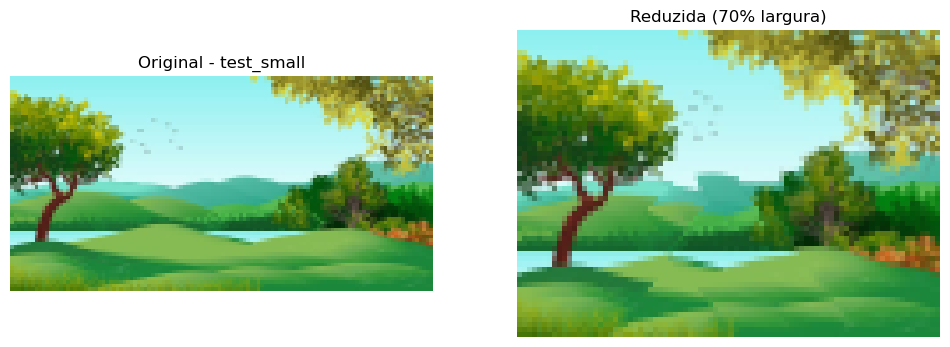

uint8
(61, 120, 3)
uint8
(36, 120, 3)


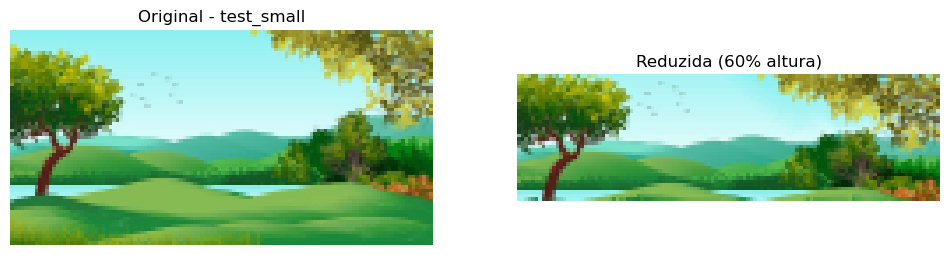

In [11]:
# Imagem de teste
# Abrir imagem e converter para ndarray
img1 = np.array(Image.open("test_small.png").convert("RGB"))
resized_img1 = resize_image_seam_carving(img1, scale_factor=0.7, direction='largura')

print(img1.dtype)  # Deve ser uint8
print(img1.shape)  # Tamanho original

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original - test_small")
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reduzida (70% largura)")

# Verificação do tipo e formato da imagem redimensionada
print(resized_img1.dtype)  # Deve ser uint8
print(resized_img1.shape)  # Tamanho que tem de ser 70% do original

plt.imshow(resized_img1)
plt.axis('off')
plt.show()


# Segunda imagem
img2 = np.array(Image.open("test_small.png").convert("RGB"))
resized_img2 = resize_image_seam_carving(img2, scale_factor=0.6, direction='altura')

print(img2.dtype)  # Deve ser uint8
print(img2.shape)  # Tamanho original

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original - test_small")
plt.imshow(img2)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reduzida (60% altura)")

print(resized_img2.dtype)  # Deve ser uint8
print(resized_img2.shape)  # Tamanho que tem de ser 60% do original

plt.imshow(resized_img2)
plt.axis('off')
plt.show()

In [ ]:
# Imagens pedidas no enunciado
# Abrir imagem e converter para ndarray
img1 = np.array(Image.open("img-broadway_tower.jpg").convert("RGB"))
resized_img1 = resize_image_seam_carving(img1, scale_factor=0.7, direction='largura')

print(img1.dtype)  # Deve ser uint8
print(img1.shape)  # Tamanho original

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original - img-broadway_tower")
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reduzida (70% largura)")

# Verificação do tipo e formato da imagem redimensionada
print(resized_img1.dtype)  # Deve ser uint8
print(resized_img1.shape)  # Tamanho que tem de ser 70% do original

plt.imshow(resized_img1)
plt.axis('off')
plt.show()


# Segunda imagem
img2 = np.array(Image.open("img-brent-cox-unsplash.jpg").convert("RGB"))
resized_img2 = resize_image_seam_carving(img2, scale_factor=0.6, direction='altura')

print(img2.dtype)  # Deve ser uint8
print(img2.shape)  # Tamanho original

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original - img-brent-cox-unsplash")
plt.imshow(img2)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reduzida (60% altura)")

print(resized_img2.dtype)  # Deve ser uint8
print(resized_img2.shape)  # Tamanho que tem de ser 60% do original

plt.imshow(resized_img2)
plt.axis('off')
plt.show()

### **5) Questões Éticas** 

#### **5.1) Se colaborou com alguém fora do seu grupo, indique aqui os respetivos nomes.**

#### ***Resposta***

Não colaborámos com ninguém fora do grupo.

#### **5.2) Deve citar todas as fontes utilizadas fora do material da UC.**

#### ***Resposta***

Para além do material da UC, utilizámos as fontes descritas acima para a questão 3.3.4).
